In [2]:
import json
import re
import numpy as np
import pandas as pd
import jsonlines
import urllib
from bs4 import BeautifulSoup
from difflib import SequenceMatcher


# 防止ssl报错
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pickle
import sys
import urllib
from cProfile import label

import bs4
import urllib3.util
import os

from urllib.error import HTTPError

import requests
import xlrd
import xlwt
from xlutils.copy import copy

from tqdm import tqdm

In [6]:
main_path = ''  #爬取结果主路径
clean_path = '' #官员名单路径

In [3]:
def home(name,job):
        # 判断百度百科上是否存在这个人的页面，若存在多义项情况，根据job判断，选择与job最相近的页面
        # 访问、下载html网页
    url = 'https://baike.baidu.com/item/' + urllib.parse.quote(name) + '?force=1'  # 请求地址（多义词列表界面）
        # 请求头部，伪造浏览器，防止爬虫被反
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36'
     }
        # 利用请求地址和请求头部构造请求对象
    req = urllib.request.Request(url=url, headers=headers, method='GET')
    response = urllib.request.urlopen(req)  # 发送请求，获得响应
    text = response.read().decode('utf-8')  # 读取响应，获得文本
        # 解析html网页
    soup = BeautifulSoup(text, 'html.parser')  # 创建soup对象，获取html源码
        # 检查该人名的百科页面是否存在sorryCont标签，来判断该页面是否存在
    if soup.find('p', class_='sorryCont'):
        link = ""
        score_max=0
        return link,score_max
    link = ""
    link_list_all= [[]]
    if soup.find('div', attrs={'class': 'lemmaWgt-subLemmaListTitle'}):
        # 进入到多义词列表的页面，需要从多义词列表中找到匹配待检索实体的义项描述的链接
        #计算官员职位与多义词列表中官员标题（包含职位）的文本相似度
        li_label = soup.find_all('li', attrs={'class': 'list-dot list-dot-paddingleft'})
        
        for li in li_label:
            link_list= []
            para_label = li.find('div', attrs={'class': 'para'})
            text = para_label.get_text()
            res = text.split('：')[-1]
            a_label = li.find('a')
            redirect_url = "https://baike.baidu.com" + a_label['href']
            link_list.append(redirect_url)
            link_list.append(res)
            score = SequenceMatcher(None,res,job).ratio()
            link_list.append(score)
                # 根据res与job的最大匹配分数，定位到唯一的百度百科界面
            link_list_all.append(link_list)
            
        score_max= max([i[2] for i in link_list_all[1:]])
        score_index = [i[2] for i in link_list_all[1:]].index(score_max)+1
        link = link_list_all[score_index][0]
        return link,score_max

    elif soup.find('dd', attrs={'class':'lemmaWgt-lemmaTitle-title'}):
        # 如果subject对应的页面是单义词，则直接获取页面下的所有超链接
        link = url
        score_max=1
        return link,score_max
    else:
        # 可能是未知页面，返回None
        # 存在是多义词，在其义项描述不在百度百科多义词列表里。
        return None

    if len(link) == 0:
        # 说明百度百科页面中没有相应的义项描述与之对应，返回None
        return None

In [4]:
def claw(url):
    # 访问、下载html网页，为防止多人重名页面需要人工选择。
    # 请求头部，伪造浏览器，防止爬虫被反
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
    }
    # 利用请求地址和请求头部构造请求对象
    req = urllib.request.Request(url=url, headers=headers, method='GET')
    response = urllib.request.urlopen(req)  # 发送请求，获得响应
    text = response.read().decode('utf-8')  # 读取响应，获得文本
    # ----------------------------------------------------------------------------------------------------
    # 解析html网页
    soup = BeautifulSoup(text, 'html.parser')  # 创建soup对象，获取html源码
    # 删除人物履历中的description内容标签，因为它的文本是噪音数据，有span和div标签
    desc_tag = soup.find_all(class_='description')
    [i.clear() for i in desc_tag]

    # 处理基本信息：过滤数据，去掉空白
    intro_tag = soup.find('div', class_="lemma-summary")  # 获取百科基本信息列表
    intro_after_filter = re.sub('\n+', '', intro_tag.get_text())  # 去除换行
    #intro_after_filter = [''.join(i.split()) for i in intro_after_filter]  # 去除/0a乱码
    # 将字符串列表连成字符串并返回
    intro_after_filter = ''.join(intro_after_filter.split())
    # print(intro_after_filter)

    # 获取html内容便签部分tag<main-content>
    soup_main = soup.find('div', class_=re.compile('main-content J-content'))

    # 抽取信息框数据
    profile_tag = soup_main.find('div', class_=re.compile('basic-info'))
    name_tag = profile_tag.find_all('dt', class_="basicInfo-item name")  # 找到所有dt标签，返回一个标签列表
    value_tag = profile_tag.find_all('dd', class_="basicInfo-item value")  # 找到所有dd标签，返回一个标签列表
    profile_info = {}
    namelist = []
    valuelist = []

    for i in name_tag:  # 将所有dt标签内容存入列表
        name = i.get_text()
        name = ''.join(name.split())  # 去除/0a乱码
        namelist.append(name)
    for i in value_tag:  # 将所有dd标签内容存入列表
        value = i.get_text().strip(' ')
        # value = re.sub('\n+', '、', i.get_text()).strip('、')  # 老师不让删除换行符
        # value = ''.join(value.split())  # 删除可能存在的乱吗/0a，但一块把空格删除了，实际上不需要
        valuelist.append(value.strip('\n'))
    for i, j in zip(namelist,
                    valuelist):  # 多遍历循环，zip()接受一系列可迭代对象作为参数，将对象中对应的元素打包成一个个tuple（元组），然后返回由这些tuples组成的list（列表）。
        profile_info[i] = j
    # print(profile_info)

    # 抽取人物履历信息、担任职位、人物经历等所有栏目信息v3.0
    br_text_list = []
    for br in profile_tag.next_siblings: #获取与tag同级的兄弟节点
        # print(br)
        if type(br) is bs4.element.Tag:  # 判断br是不是一个标签
            # 判断是否是栏目标题下的内容标签
            if br.name == 'div' and "class" in br.attrs:
                attrs = ''.join(br.attrs['class'])
                if re.match(r'para-titlelevel-2', attrs):  # 当出现栏目2级标题时，获取标题名称
                    title = br.find(class_='title-text').contents[1]
                    # print(title)
                    br_text_list.append('title-2: ' + title)
                elif re.match(r'para-titlelevel-3', attrs):  # 当出现栏目3级标题时，获取标题名称
                    title = br.find(class_='title-text').contents[1]
                    # print(title)
                    br_text_list.append('title-3: ' + title)
                elif attrs == 'para':
                    br_text = re.sub('\n+', '', br.get_text())
                    # print(br_text)
                    br_text_list.append(''.join(br_text.split()))
                
                    # print(book_dict)

            # html的main主标签结束判断，<div id="J-main-content-end-dom">
            elif br.name == 'div' and "id" in br.attrs:
                attrs = ''.join(br.attrs['id'])
                if re.match(re.compile('J-main-content-end-dom'), attrs):
                    break
        else:
            continue



    return intro_after_filter, profile_info, br_text_list


In [5]:
def download(intro, profile_dict, br_text_list):
    project_path = os.getcwd()
    # print('project_path:' + project_path)

    # 保存百科基本信息
    # if not os.path.exists('introduction'):
    #     os.mkdir('introduction')
    # introduction_file = project_path + '/introduction/' + name + '.json'
    # print(introduction_file)
    # with open(introduction_file, 'w', encoding='utf-8') as f:
        # 转换成json格式输出
    intro_dict = {'基本信息': intro}
        # 防止json编码时中文ascii乱码，用ensure_ascii=False
        # intro_dict_json = json.dumps(intro_dict, indent=4, ensure_ascii=False)

        # f.write(intro_dict_json + '\n')
    # print('introduction输出完毕')

    # 将信息框数据以json格式输出
    # with open(introduction_file, 'a+') as f:
        # profile_dict_json = json.dumps(profile_dict, indent=4, ensure_ascii=False, sort_keys=False)
        # f.write(profile_dict_json + '\n')
    '''
    # 保存信息框数据到excel
    if not os.path.exists('profile'):
        os.mkdir('profile')

    profile_file = project_path + '/profile/' + 'profile.csv'
    field_list = ['中文名', '外文名', '别名', '性别', '学位', '职称', '国籍', '民族', '出生地', '籍贯', '出生日期', '逝世日期',
                  '星座', '血型', '身高', '体重', '毕业院校', '职业', '经纪公司', '代表作品', '主要成就', '生肖', '语种', '特长', '粉丝名']
    if not os.path.exists(profile_file):
        workbook = xlwt.Workbook(encoding='utf-8')
        output_sheet = workbook.add_sheet('profile_sheet', cell_overwrite_ok=True)
        for i in range(len(field_list)):
            output_sheet.write(0, i, field_list[i])
        workbook.save(profile_file)

    rb = xlrd.open_workbook(profile_file)
    rows_num = rb.sheet_by_name('profile_sheet').nrows
    # print(rows_num)
    wb = copy(rb)
    output_sheet = wb.get_sheet(0)
    # print(profile)
    for i in range(len(field_list)):
        if profile_dict.get(field_list[i]):
            output_sheet.write(rows_num, i, profile_dict.get(field_list[i]))
        else:
            continue
    os.remove(profile_file)
    wb.save(profile_file)
    '''

    # 保存人物履历、职务、研究等栏目内容到基本信息.txt中
    # api返回json数据，在web中进行展示
    cv_output = {}
    # with open(introduction_file, 'a+') as f:
    # print(br_text_list)
    # 转换成json格式输出
    key_2 = ''
    value = ''
    key_3 = ''
    output_dict_2 = {}
    output_dict_3 = {}
    for i in range(len(br_text_list)): #一共有多少个元素，从第一个元素开始走起
        # print(i)
        item = br_text_list[i]
        if isinstance(item, str): #判断item是否是字符
            # 2级标题
            if item.startswith('title-2'): #用于检查字符串是否是以指定子字符串开头
                key_2 = item.split(': ')[1]
                # continue
            # 3级标题
            elif item.startswith('title-3'):
                key_3 = item.split(': ')[1]
                # continue
            else:
                value += item

            # 根据下一索引的值判断第2级标题还是第3级标题，然后返回字典形式的内容
            if i+1 < len(br_text_list):
                if br_text_list[i+1].startswith('title-3'):
                    if key_3:
                        output_dict_3.update({key_3: value})
                        key_3 = ''
                        value = ''
                        continue
                    elif key_2 and value:
                        output_dict_3.update({'': value})
                        value = ''
                        continue
                elif br_text_list[i+1].startswith('title-2'):
                    if key_3:
                        output_dict_3.update({key_3: value})
                        output_dict_2 = {key_2: output_dict_3}
                        cv_output.update(output_dict_2)
                        # output_dict_2_json = json.dumps(output_dict_2, indent=4, ensure_ascii=False)
                        # f.write(output_dict_2_json + '\n')
                        key_3 = ''
                        value = ''
                        output_dict_2 = {}
                        output_dict_3 = {}
                        continue
                    else:
                        output_dict_2 = {key_2: value}
                        cv_output.update(output_dict_2)
                        # output_dict_2_json = json.dumps(output_dict_2, indent=4, ensure_ascii=False)
                        # f.write(output_dict_2_json + '\n')
                        value = ''
                        output_dict_2 = {}
                        continue
                else:
                    continue
            else:
                if str(br_text_list[-1]).startswith('title'):
                    value = ''

                if key_3:
                    output_dict_3.update({key_3: value})
                    output_dict_2 = {key_2: output_dict_3}
                else:
                    output_dict_2 = {key_2: value}
                cv_output.update(output_dict_2)
                # output_dict_2_json = json.dumps(output_dict_2, indent=4, ensure_ascii=False)
                # f.write(output_dict_2_json + '\n')
        elif isinstance(item, list):
            cv_output.update({key_2: item})
            # output = json.dumps({key_2: item}, indent=4, ensure_ascii=False)
            # f.write(output)
            continue

    return intro_dict, profile_dict, cv_output

In [11]:
###文本切片函数

valid_char = re.compile(u'[\u4e00-\u9fa5a-zA-Z0-9]')

stop_big = (
        ';'
        '；'
        '｡'    # == '\uFF61' Halfwidth ideographic full stop   一种句号
        '。'   # == '\u3002'  Ideographic full stop  。一种句号
        '！'  # == '\uFF01'  # Fullwidth exclamation mark ！
        '!'
        '？'  #  == '\uFF1F' # Fullwidth question mark
        '?'
        '\n'  # 软回车 在Windows 中表示换行且回到下一行的最开始位置。
        '|'
        )


stops_space = (
    ' '
    '\xa0'    # 空格:不间断空白符 &nbsp(non-breaking space)，
    '\u3000'  # 顶格 
    '\u2002'  # 空格
    '\u2003'  # 2空格
    '\u3000') # '\|'
# \u3000全角的空白符，跟nbsp不一样，可被换行间断的，常用于制造缩进。
# \u3000同时属于CJK字符的CJK标点符号区块内，是空白字符之一。

stops_small = (
    '.'
    '，'  # chinese 逗号
    ','  # 逗号 
    '、'  # chinese 顿号
    '/'  # '/'
    '：'  # 冒号
    ':') # 冒号


def no_len_cut(sentence = "。你\u3002在北京\n我,你|是谁?在干嘛。", keep_split = True):
    _stop_big = f"[{stop_big}]"
    if not keep_split:
        items = re.split(_stop_big, sentence)
        return items
    else:
        items = re.split(f"({_stop_big})", sentence)
        result = []
        for i in range(0,len(items),2):
            if i+1 <len(items):
                if items[i]:
                    result.append(items[i]+items[i+1])
        if items[-1]:
            result.append(items[-1])
        return result


def with_len_cut(text = '1。2|34!sdf。', max_len = 500, window_size=10):
    """
    with_len_cut("12345678",4,1)
    Out[12]: ['1234', '4567', '78']
    遇到分隔符会直接截断，使得文本更加连贯
    
    with_len_cut("123。45678",5,1)
    Out[13]: ['123。', '45678', '8']


     截取回推法
    :param text: 文本字符串
    :param max_len: 限制的最大长度
    :window_size :滑动窗口size，加强连贯性
    :return:list-所有切分后的文本列表
    """
    valid_char = re.compile(u'[\u4e00-\u9fa5a-zA-Z0-9]')
    new_test = []

    stop_big_in = f'[{"".join([i for i in stop_big])}]'
    #print("stop_big_in", stop_big_in)
    while text.__len__() >= max_len:
        cut_text = text[:max_len]
        cut_list = list(cut_text) # list("abc") == ['a', 'b', 'c']
        cut_list.reverse()
        cur = ''.join(cut_list)
        cut_label = 0
        
        if re.search(stop_big_in, cur) == None:
            try:
                # 逗号顿号冒号
                stop_small_in = r'[{stops_small + stops_space}]'
                stop_index = re.search(f'{stop_small_in}', cur).start()
                cut_label = 1
            except:
                stop_index = 0
        else:
            cut_label = 1
            stop_index = re.search(stop_big_in, cur).start()
            
        cut_text = cut_text[:cut_text.__len__() - stop_index]
        new_test.append(cut_text)
        
        if stop_index > 0 or cut_label == 1:
            back_index = max_len - stop_index  # 滑动窗口size=
            if max_len - stop_index <= 0:
                back_index = max_len 
            text = text[back_index:]
            
        elif stop_index == 0:
            back_index = max_len - stop_index - window_size  # 滑动窗口size=
            if max_len - stop_index - window_size <= 0:
                back_index = max_len - window_size
            text = text[back_index:]   
            
        
    res_text = new_test
    res_text.append(text)
    clean_res_text = [x  for x in res_text if valid_char.search(x)]
    return clean_res_text

In [7]:
def request(url):
    intro_after_filter, profile_info, br_text_list = claw(url)
    intro_dict, profile_dict, cv_output = download(intro_after_filter, profile_info, br_text_list)
    output = [intro_dict, profile_dict, cv_output]
    #intro_dict为人物页面中的简介，profile_dict为个人信息表，cv_output为正文内容
    output_json = json.dumps(output[0], indent=4, ensure_ascii=False) #针对三种信息分别构建json
    intro=json.loads(output_json.replace("\n",""))
    output_json = json.dumps(output[1], indent=4, ensure_ascii=False) #针对三种信息分别构建json
    profile=json.loads(output_json.replace("\n",""))
    output_json = json.dumps(output[2], indent=4, ensure_ascii=False) #针对三种信息分别构建json
    cv=json.loads(output_json.replace("\n",""))
    
    return intro, profile, cv


# 爬取百度百科简历数据

In [8]:
#输入合并好的tentcent数据
tr_path = clean_path + 'tencent_clean.csv'
data = pd.read_csv(tr_path, encoding='gb18030')
#构造结果df
result = data
result["intro"] =''
result["score"]= ''
result["profile"] =''
result["cv"] =''
result["url"] =''


In [ ]:
#开始爬虫，爬取不到的插入空值
#result = pd.read_csv(main_path+"temp.csv", encoding='gb18030') 
for i in tqdm(range(14799,len(result))):
    id1 = data.id[i]
    name1 = data.name[i]
    job1 = data.position[i]

    try:
        url1,score1 = home(name1,job1)
        intro1,profile1,cv1= request(url1)
    except:
        
        pass
    else:
        url1,score1 = home(name1,job1)
        intro1,profile1,cv1= request(url1)
        result.loc[i,"intro"] =str(intro1)
        result.loc[i,"score"]= score1
        result.loc[i,"profile"] =str(profile1)
        result.loc[i,"cv"] =str(cv1)
        result.loc[i,"url"] =url1
        
    if  i % 50 == 0:
        result.to_csv(main_path+"temp.csv", encoding="gb18030",index=None)
        result = pd.read_csv(main_path+"temp.csv", encoding='gb18030')
        print(i)
    #if这一步是为了避免爬虫脚本崩溃导致内存清空的情况，所以每爬取50个样本临时保存一次。如果出现卡死或崩溃重新运行这一步时，要解除该模块第一步的注释。

空值数量： 8017


<AxesSubplot:>

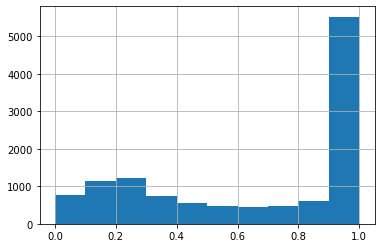

In [20]:
print('空值数量：',result.cv.isna().sum())
#result.score.quantile([0.25,0.5,0.75])
result.score.hist()

In [9]:
##对样本进行截尾
# df = pd.read_csv(main_path+'01spider_all_raw.csv', encoding='gb18030')
# df.drop('Unnamed: 0',axis=1,inplace=True) 
# df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
# cut=df.score.describe(percentiles = [.01])["1%"] #截尾值
# df1=df.drop(df[df.score < cut].index, inplace=False) 
# print("删去的数量：",-len(df1)+len(data))
# df1.reset_index(inplace=True)
# df1.drop('index',axis=1,inplace=True) 

In [22]:

#注意，score为1的时候说明直接跳转至百度百科人名主页，但也不一定对应该行官员，原因在于百度百科中只有此一特定人名，所以为了便于判断，
#新增一列position_sub，为position通过结巴分词的过结果，新增一列position_in_cv_score，是position_sub中的词语在cv变量中的比例。
import jieba
result["position_sub"] = result.position.apply(jieba.lcut)
for i in range(len(result)):
    if result["cv"][i] != '':
        num = 0
        for word in result["position_sub"][i]:
            cv = str(result["cv"][i])
            if word in cv:
                num =num+1
        result.loc[i,"position_in_cv_score"]=num/len(result["position_sub"][i])
result.to_csv(main_path+"01spider_cv_result.csv", encoding="gb18030",index = None)

<AxesSubplot:>

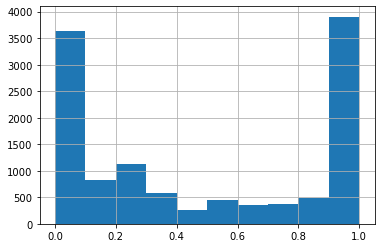

In [93]:
result["position_in_cv_score"].hist()